In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from skimage import io
from skimage import feature
from skimage.exposure import equalize_adapthist
from skimage.feature import canny
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import remove_small_objects  
from scipy.signal import find_peaks

In [2]:
sys.path.insert(0, '/Users/shrilakshmisbonageri/Desktop/UW/DIRECT/capstone/musical-robot/musicalrobot')

In [3]:
import irtemp

In [4]:
from irtemp import centikelvin_to_celsius

### Function to load the input file

In [5]:
def input_file(file_name):
    ''' To load the imput file as an array.
    Args:
        file_name (string) : Name of the file to be loaded as it is 
        saved on the disk. Provide file path if it is not in
        the same directory as the jupyter notebook.
    Returns:
        In case of a video, returns an array for each frame
        in the video.
        In case of an image, return an array.    
    '''
    frames = io.imread(file_name)
    return frames

In [8]:
frames = input_file('../doc/PPA_Melting_6_14_19.tiff')
crop_frame = []
for frame in frames:
    crop_frame.append(frame[40:100])

### Function to flip the frames horizontally and vertically to correct for the mirroring during recording

In [9]:
def flip_frame(frames):
    ''' To flip all the loaded frames horizontally and vertically
        to correct for the mirroring during recording.
        Args:
        frames(Array): An array containing an array for each frame
        in the video or just a single array in case of an image.
        Returns:
        Flipped frames that can be processed to get temperature data.
    '''
    flip_frames = []
    for frame in frames:
        f_frame = np.fliplr(frame)
        flip_frames.append(np.flipud(f_frame))
    return flip_frames

In [10]:
flip_frames = flip_frame(crop_frame)

In [11]:
type(flip_frames)

list

### Function to detect edges, fill and label the samples.

In [12]:
def edge_detection(frames):
    ''' To detect the edges of the wells, fill and label them to
    determine their centroids.
    Args:
    frames: The frames to be processed and determine the
    sample temperature from.
    Returns:
    labeled_samples: All the samples in the frame are labeled
    so that they can be used as props to get pixel data from.
    '''
    edges = feature.canny(frames[0]/1500)
    filled_samples = binary_fill_holes(edges)
    cl_samples = remove_small_objects(filled_samples,min_size = 20)
    labeled_samples = label(cl_samples)
    return labeled_samples

In [13]:
labeled_samples = edge_detection(flip_frames)

In [14]:
flip_frames[0].shape

(60, 160)

In [15]:
labeled_samples.shape

(60, 160)

In [16]:
assert flip_frames[0].shape == labeled_samples.shape,'SHape'

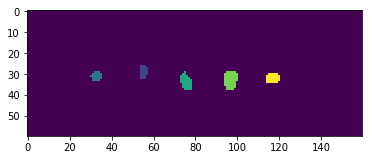

In [17]:
plt.imshow(labeled_samples)

### Function to determine centroids of all the samples

In [18]:
def regprop(labeled_samples,frames,n_samples):
    ''' Determines the area and centroid of all samples.
        Args:
        labeled_samples(array): An array with labeled samples.
        flip_frames (array) : Original intensity image to determine
        the intensity at sample centroids.
        Returns:
        A dataframe with information about samples.
    '''
    regprops = {} 
    for i in range(len(frames)):
        props = regionprops(labeled_samples, intensity_image=frames[i])
        x = np.zeros(len(props)).astype(int)
        y = np.zeros(len(props)).astype(int)
        area = np.zeros(len(props))
        perim = np.zeros(len(props))
        intensity = np.zeros(len(props),dtype=np.float64)
        plate = np.zeros(len(props),dtype=np.float64)
        plate_coord = np.zeros(len(props))
       
        c = 0
        for prop in props:
            x[c] = int(prop.centroid[0])
            y[c] = int(prop.centroid[1])
            #print(y[c])
            area[c] = prop.area
            perim[c] = prop.perimeter
            intensity[c] = frames[i][x[c]][y[c]]
            plate[c] = frames[i][x[c]][y[c]+10]
            plate_coord[c] = y[c]+10
            c = c + 1
            
        regprops[i] = pd.DataFrame({'X': x, 'Y': y,'Plate':plate,'Plate_coord':plate_coord ,'Area': area,
                                'Perim': perim, 'Mean Intensity': intensity},dtype=np.float64)
        regprops[i].sort_values(['Y','X'],inplace=True)
        if len(regprops[i]) != n_samples:
            print('Wrong number of samples are being detected in frame %d' %i)    
    return regprops

In [20]:
regprops = regprop(labeled_samples,flip_frames,5)

In [21]:
len(regprops[0])

5

In [22]:
regprops[0]

,X,Y,Plate,Plate_coord,Area,Perim,Mean Intensity
1,31.0,32.0,29465.0,42.0,23.0,15.071068,29308.0
0,28.0,55.0,29476.0,65.0,25.0,16.828427,29332.0
2,33.0,75.0,29534.0,85.0,38.0,21.485281,29329.0
3,32.0,96.0,29472.0,106.0,54.0,25.071068,29303.0
4,32.0,116.0,29513.0,126.0,32.0,18.242641,29336.0


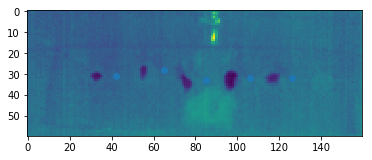

In [23]:
plt.imshow(flip_frames[0])
plt.scatter(regprops[0]['Plate_coord'],regprops[0]['X'])

In [59]:
for i in range(len(flip_frames)):
    if len(regprops[i]) != 5:
        print('Wrong number of samples %d' %i)

In [60]:
len(regprops[1])

5

### Function to obtain temperature of samples and plate temp

In [25]:
def sample_temp(regprops,frames):
    ''' Function to concatenate all the obtained temperature data
        from the pixel values into lists.
        Args:
        regprops: The dictionary of dataframes containing temperature data.
        frames: The array of frames to be processed to obtain temperature data.
    '''
    temp = []
    plate_temp = []
    for j in range(len(regprops[1])):
        temp_well = []
        plate_well_temp = []
        for i in range(len(frames)):
            temp_well.append(centikelvin_to_celsius(regprops[i]['Mean Intensity'][j]))
            plate_well_temp.append(centikelvin_to_celsius(regprops[i]['Plate'][j]))
        temp.append(temp_well)
        plate_temp.append(plate_well_temp)
    return temp,plate_temp

In [26]:
temp, plate_temp = sample_temp(regprops,flip_frames)

In [29]:
len(temp)

5

In [27]:
type(temp)

list

In [28]:
type(plate_temp)

list

In [ ]:
plt.plot(plate_temp[1],temp[1])

In [ ]:
np.asarray(temp).shape

In [ ]:
melting_point = find_peaks(np.asarray(temp[1]),distance=20)

In [ ]:
melting_point

In [ ]:
len(flip_frames)

### Image equalization

In [33]:
def image_eq(n_frames,frames):
    '''Function to obtained an equalized image using all the frames
       in the video.
       Args:
       n_frames(int): The number of frames in the video.
       frames(List): List of arrays of frames in the video.
       Returns:
       img_eq: Equalized image  
    '''
    for II in range(n_frames):
        frame = frames[II]
        img_eq = (frame - np.amin(frame))/(np.amax(frame)-np.amin(frame))
        if II == 0:
            img_ave = img_eq
        else:
            img_ave = img_ave + img_eq
    img_average = img_ave/n_frames
    img_eq = (img_ave - np.amin(img_ave))/(np.amax(img_ave)-np.amin(img_ave))
    return img_eq

### Pixel sum

In [54]:
def pixel_sum(frame):
    ''' Funtion to determine sum of pixels over all the rows and columns
        to obtain plots with peaks at the sample position in the array.
        Args:
        frame(array): An array of an image
        Returns:
        column_sum: Sum of pixels over all the columns
        row_sum: Sum of pixels over all the rows
        Also returns plots of column sum and row sum.
    '''
    rows = frame.shape[0]
    columns = frame.shape[1]
    column_sum = []
    for i in range(0,columns):
        column_sum.append(sum(frame[:,i]))
    row_sum = []
    for j in range(0,rows):
        row_sum.append(sum(frame[j,:]))
    column_sum = [x * -1 for x in column_sum]
    row_sum = [x * -1 for x in row_sum]
    plt.plot(range(len(column_sum)),column_sum)
    plt.xlabel('X-coordinate value')
    plt.ylabel('Sum of pixel values over columns')
    plt.show()
    plt.plot(range(len(row_sum)),row_sum)
    plt.xlabel('Y-coordinate value')
    plt.ylabel('Sum of pixel values over rows')
    plt.show()
    return column_sum,row_sum


In [55]:
pixel_frames = input_file('../doc/CHCl_CA_DES_5_31_19.tiff')

In [56]:
img_eq = image_eq(len(pixel_frames),pixel_frames)

In [57]:
pixel_frames[0].shape

(120, 160)

In [58]:
img_eq.shape

(120, 160)

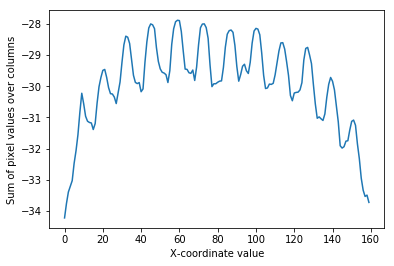

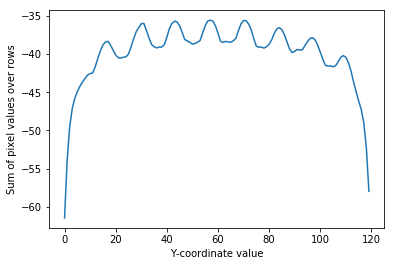

In [41]:
column_sum, row_sum = pixel_sum(img_eq)

In [43]:
len(column_sum)

160

In [44]:
len(row_sum)

120

### Peak values in dataframe

In [45]:
def peak_values(column_sum,row_sum,n_columns,n_rows,image):
    ''' Function to find peaks from the column_sum and row_sum arrays
        and return a dataframe with sample locations.
        Args:
        column_sum: Sum of pixel values over all the columns in the
        image array.
        row_sum: Sum of pixel values over all the rows in the
        image array.
        n_columns: Number of columns of samples in the image
        n_rows: Number of rows of samples in the image.
        image: Image to be processed
        Returns: 
        sample_location: A dataframe containing sample and plate locations and a plot with locations
        superimposed on the image to be processed.
        
    '''
    column_peaks = find_peaks(column_sum,distance=10)
    column_peaks = column_peaks[0]
    row_peaks = find_peaks(row_sum,distance=10)
    row_peaks = row_peaks[0]
    X = []
    Y = []
    plate_location = []
    i = 0
    j = 0
    for i in range(0,n_rows):
        for j in range(0,n_columns):
            Y.append(column_peaks[j])
            if j == 0:
                plate_location.append(int((Y[j]-0)/2))
            else:
                plate_location.append(int((Y[j] + Y[j-1])/2))
            j = j + 1
            X.append(row_peaks[i])
            
        i = i + 1
    
    sample_location = pd.DataFrame(list(zip(X, Y, plate_location)),columns =['X', 'Y','plate_location'])
    plt.imshow(image)
    plt.scatter(sample_location['Y'],sample_location['X'],s=4)
    plt.scatter(sample_location['plate_location'],sample_location['X'],s=4)
    plt.show()
    return sample_location

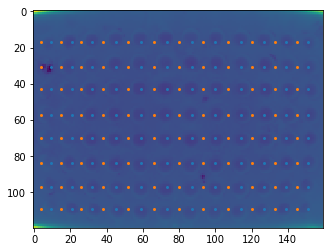

In [46]:
well_location = peak_values(column_sum,row_sum,12,8,img_eq)

In [48]:
type(well_location)

pandas.core.frame.DataFrame

In [47]:
len(well_location)

96

### Sample temp and plate temp in list

In [49]:
def pixel_intensity(sample_location, frames, x_name, y_name, plate_name):
    ''' Function to find pixel intensity at all sample locations
        and plate locations in each frame.
        Args:
        sample_location(dataframe): A dataframe containing sample and plate locations.
        frames(list or array): An array of arrays containing all the frames of a video.
        x_name(string): Name of the column in sample_location containing the row values of the samples.
        y_name(string): Name of the column in sample_location containing the column values of the samples.
        plate_name(string): Name of the column in sample_location containing the column values of the
        plate location.
    '''
    temp = []
    plate_temp = []
    x = sample_location[x_name]
    y = sample_location[y_name]
    p = sample_location[plate_name]
    for i in range(len(sample_location)):
        temp_well = []
        plate_well_temp = []
        for frame in frames:
            temp_well.append(centikelvin_to_celsius(frame[x[i]][y[i]]))
            plate_well_temp.append(centikelvin_to_celsius(frame[x[i]][p[i]]))
        temp.append(temp_well)
        plate_temp.append(plate_well_temp)
    return temp,plate_temp

In [50]:
pixel_sample,pixel_plate = pixel_intensity(well_location, pixel_frames, 'X','Y','plate_location')

In [53]:
type(pixel_sample)

list

In [51]:
len(pixel_sample)

96

In [52]:
len(pixel_sample[1])

6668

In [ ]:
len(pixel_plate)

In [ ]:
len(pixel_plate[1])